In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g`. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import spacy
import nltk
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from collections import Counter
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier


In [8]:
TRAIN_PATH ='data\BBC News Train.csv'

In [9]:
df = pd.read_csv(TRAIN_PATH)

In [10]:
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


**Checking number of unique articles in training set**

In [12]:
df.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

In [12]:
#we will remove duplicate values from training data

In [14]:
df.Category.value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

<AxesSubplot: ylabel='Category'>

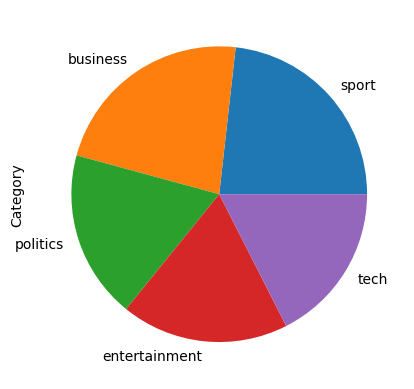

In [15]:
df.Category.value_counts().plot(kind="pie")

In [16]:
#data is almost balanced

In [17]:
duplicates = df[(df["Text"].duplicated() == True)]

print (duplicates.shape)

(50, 3)


In [18]:
duplicates["Category"].value_counts()

tech             27
entertainment    10
politics          8
sport             4
business          1
Name: Category, dtype: int64

<AxesSubplot: ylabel='Category'>

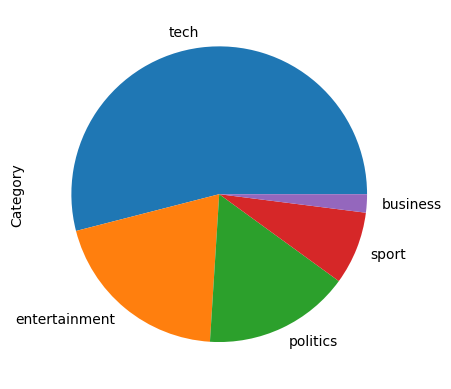

In [19]:
duplicates["Category"].value_counts().plot(kind="pie",)

In [20]:
# we need to handel these duplicate values

In [21]:
# dropinng the duplicate values

In [22]:
df= df.drop_duplicates(subset=['Text'])

In [23]:
duplicates = df[(df["Text"].duplicated() == True)]

duplicates["Category"].value_counts()

Series([], Name: Category, dtype: int64)

# Text-processing

In [26]:
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def preprocessDataset(train_text):
       
    #word tokenization using text-to-word-sequence
    train_text= str(train_text)
    tokenized_train_set = text_to_word_sequence(train_text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
        
    #stop word removal
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_set if not i in stop_words]
        
     
    #join words into sentence
    stopwordremove_text = ' '.join(stopwordremove)
        
        
    #remove numbers
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
       
        
    #--Stemming--
    stemmer= PorterStemmer()

    stem_input=nltk.word_tokenize(numberremove_text)
    stem_text=' '.join([stemmer.stem(word) for word in stem_input])
        
        
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lem_input = nltk.word_tokenize(stem_text)
    lem_text= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
        
    return lem_text

In [27]:
df['Clean_Text'] = df['Text'].apply(preprocessDataset)

In [28]:
df['category_id'] = df['Category'].factorize()[0]

#View first 10 entries of category_id, as a sanity check
df['category_id'][0:10]
df.head(20)

,ArticleId,Text,Category,Clean_Text,category_id
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex bos launch defenc lawyer defend fo...,0
1,154,german business confidence slides german busin...,business,german busi confid slide german busi confid fe...,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indic econom gloom citizen major nati...,0
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyl govern mobil choic faster well funkie...,1
4,917,enron bosses in $168m payout eighteen former e...,business,enron bos m payout eighteen former enron direc...,0
5,1582,howard truanted to play snooker conservative...,politics,howard truant play snooker conserv leader mich...,2
6,651,wales silent on grand slam talk rhys williams ...,sport,wale silent grand slam talk rhi william say wa...,3
7,1797,french honour for director parker british film...,entertainment,french honour director parker british film dir...,4
8,2034,car giant hit by mercedes slump a slump in pro...,business,car giant hit merced slump slump profit luxuri...,0
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,focker fuel festiv film chart comedi meet fock...,4


In [29]:
category_id_df = df [['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df

,Category,category_id
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


In [30]:
df.shape

(1440, 5)

In [31]:
Feature=df["Clean_Text"]
target=df["category_id"]

In [32]:
# spliting data

X_train, X_test, y_train, y_test= train_test_split(Feature,target, test_size=0.25, random_state=0)

In [40]:
#Vectorizing data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tfidf_vect = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english') #tfidfVectorizer
Xtrain_tfidf = tfidf_vect.fit_transform(X_train.values.astype('U'))
Xtest_tfidf = tfidf_vect.transform(X_test.values.astype('U'))

**model building**

In [41]:
def helper(X_test,y_test,y_test_pred):
    accuracy_score_ = accuracy_score(y_test, y_test_pred)
    print("model Accuracy :", "{:.4f}%".format(100*accuracy_score_))

    from sklearn.metrics import classification_report
    print (classification_report(y_test,y_test_pred))


    import matplotlib.pyplot as plt
    import numpy
    from sklearn import metrics
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

    cm_display.plot()
    plt.show()


In [42]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X_train, X_test, y_train, y_test, models):
   
    for i in range(len(list(models))):
        print(list(models.keys())[i])
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        

        helper(X_test,y_test,y_test_pred)
    return 

In [45]:

# Dictionary which contains models for experiment
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(n_jobs=-1),
     "K-Neighbors Classifier": KNeighborsClassifier(n_jobs=-1),
    "XGBClassifier": XGBClassifier(n_jobs=-1), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False,),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "MultinomialNB" : MultinomialNB(),
    "RidgeClassifier" : RidgeClassifier(),
    "SGDClassifier": SGDClassifier()
}

In [56]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

def evaluate_models_(X_train, X_test, y_train, y_test,models,scoring_metrics,random_state=0):
    """
    Evaluate multiple machine learning models for a multiclass classification problem after performing a train-test split and store results in a data frame

    Parameters
    ----------
    models : dict
        Dictionary of (name, model) pairs, where name is a string and model is a scikit-learn estimator
    X : array-like, shape = (n_samples, n_features)
        Features
    y : array-like, shape = (n_samples,)
        Target labels
    scoring_metrics : list
        List of scoring metrics to use, e.g. ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
    test_size : float, int or None, optional (default=0.2)
        If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split.
        If int, represents the absolute number of test samples.
        If None, the value is set to the complement of the train size.
    random_state : int, RandomState instance or None, optional (default=0)
        Control the randomization of the train-test split

    Returns
    -------
    df : pandas DataFrame
        Data frame containing model names, and scores for each scoring metric
    """
    scores = {}
    for name, model in models.items():
        print(name)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        helper(X_test,y_test,y_pred)

        scores[name] = {}
        if 'accuracy' in scoring_metrics:
            scores[name]['accuracy'] = accuracy_score(y_test, y_pred)
        if 'precision_macro' in scoring_metrics:
            scores[name]['precision_macro'] = precision_score(y_test, y_pred, average='macro')
        if 'recall_macro' in scoring_metrics:
            scores[name]['recall_macro'] = recall_score(y_test, y_pred, average='macro')
        if 'f1_macro' in scoring_metrics:
            scores[name]['f1_macro'] = f1_score(y_test, y_pred, average='macro')
    df = pd.DataFrame(scores).transpose()
    df.index.name = 'model'
    return df



In [57]:
scoring_metrics=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# TfidfVectorizer + Model

Random Forest
model Accuracy : 93.8889%
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        86
           1       0.92      0.95      0.94        64
           2       1.00      0.89      0.94        61
           3       0.93      1.00      0.96        78
           4       0.97      0.87      0.92        71

    accuracy                           0.94       360
   macro avg       0.94      0.94      0.94       360
weighted avg       0.94      0.94      0.94       360



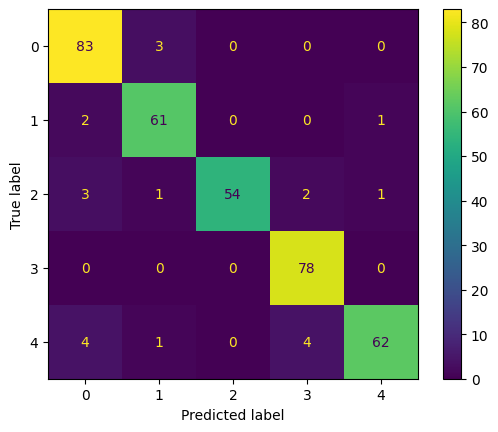

Decision Tree
model Accuracy : 79.7222%
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        86
           1       0.72      0.77      0.74        64
           2       0.82      0.67      0.74        61
           3       0.83      0.94      0.88        78
           4       0.79      0.76      0.78        71

    accuracy                           0.80       360
   macro avg       0.80      0.79      0.79       360
weighted avg       0.80      0.80      0.80       360



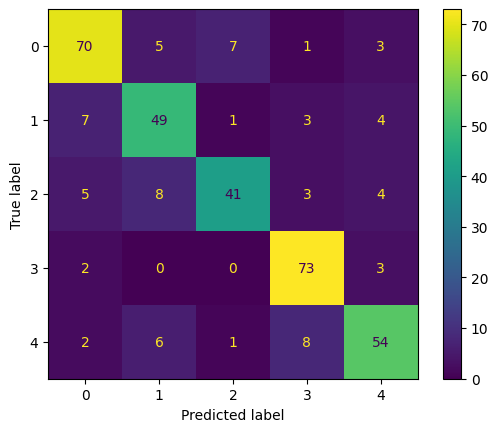

Logistic Regression
model Accuracy : 96.3889%
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        86
           1       0.94      0.97      0.95        64
           2       1.00      0.90      0.95        61
           3       0.97      1.00      0.99        78
           4       0.97      0.96      0.96        71

    accuracy                           0.96       360
   macro avg       0.97      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



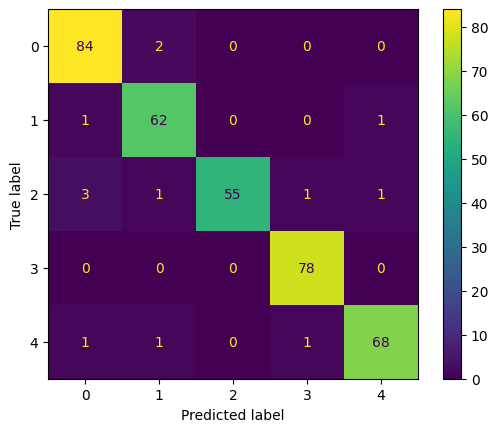

K-Neighbors Classifier
model Accuracy : 95.5556%
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        86
           1       0.89      0.97      0.93        64
           2       0.97      0.97      0.97        61
           3       0.97      1.00      0.99        78
           4       0.97      0.89      0.93        71

    accuracy                           0.96       360
   macro avg       0.95      0.96      0.95       360
weighted avg       0.96      0.96      0.96       360



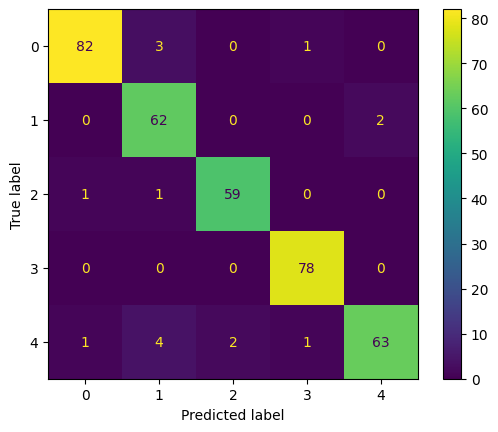

XGBClassifier
model Accuracy : 93.3333%
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        86
           1       0.92      0.92      0.92        64
           2       0.96      0.90      0.93        61
           3       0.93      1.00      0.96        78
           4       0.97      0.86      0.91        71

    accuracy                           0.93       360
   macro avg       0.94      0.93      0.93       360
weighted avg       0.94      0.93      0.93       360



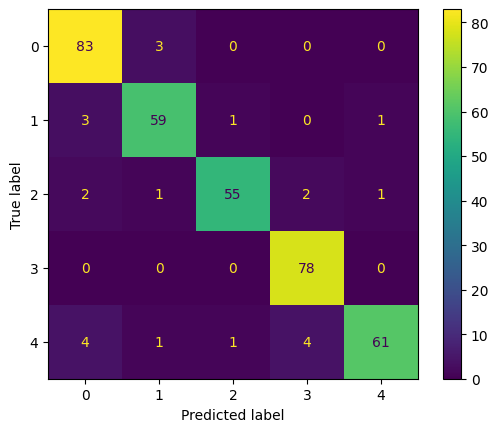

CatBoosting Classifier
model Accuracy : 96.1111%
              precision    recall  f1-score   support

           0       0.96      0.95      0.96        86
           1       0.94      0.98      0.96        64
           2       0.98      0.93      0.96        61
           3       0.95      0.99      0.97        78
           4       0.97      0.94      0.96        71

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



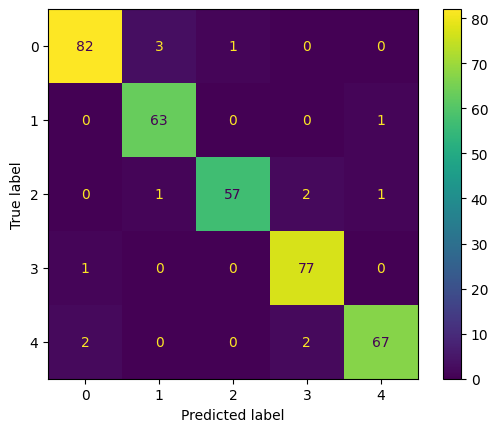

AdaBoost Classifier
model Accuracy : 76.6667%
              precision    recall  f1-score   support

           0       0.70      0.83      0.76        86
           1       0.88      0.58      0.70        64
           2       0.83      0.64      0.72        61
           3       0.67      0.96      0.79        78
           4       0.93      0.76      0.84        71

    accuracy                           0.77       360
   macro avg       0.80      0.75      0.76       360
weighted avg       0.79      0.77      0.76       360



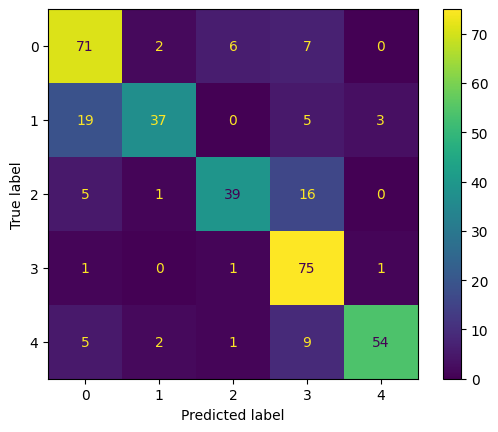

MultinomialNB
model Accuracy : 96.6667%
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        86
           1       0.94      0.98      0.96        64
           2       1.00      0.93      0.97        61
           3       0.97      1.00      0.99        78
           4       1.00      0.93      0.96        71

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



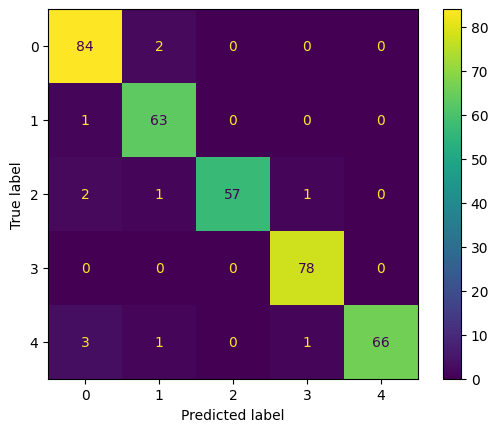

RidgeClassifier
model Accuracy : 96.9444%
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        86
           1       0.93      0.98      0.95        64
           2       1.00      0.93      0.97        61
           3       0.97      1.00      0.99        78
           4       0.97      0.96      0.96        71

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



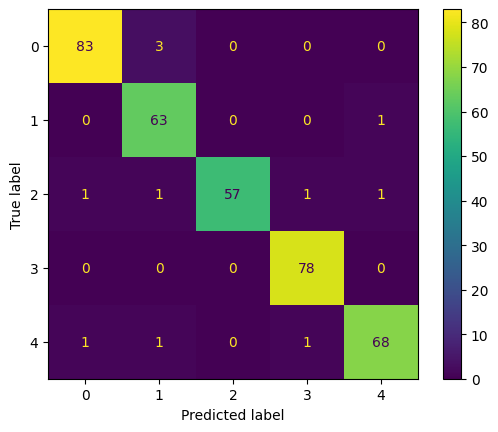

SGDClassifier
model Accuracy : 97.2222%
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        86
           1       0.94      0.98      0.96        64
           2       1.00      0.93      0.97        61
           3       0.96      1.00      0.98        78
           4       0.97      0.97      0.97        71

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



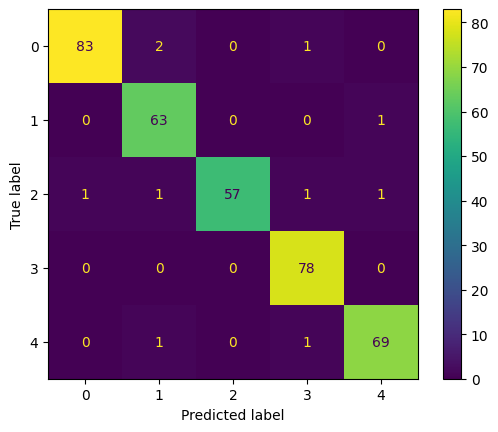

,accuracy,precision_macro,recall_macro,f1_macro
model,,,,
Random Forest,0.938889,0.944748,0.935345,0.938332
Decision Tree,0.797222,0.795641,0.789634,0.790323
Logistic Regression,0.963889,0.965929,0.960976,0.962801
K-Neighbors Classifier,0.955556,0.954670,0.955355,0.954221
XGBClassifier,0.933333,0.937157,0.929557,0.932015
CatBoosting Classifier,0.961111,0.961879,0.960626,0.960915
AdaBoost Classifier,0.766667,0.802877,0.753030,0.761275
MultinomialNB,0.966667,0.969726,0.965025,0.966665
RidgeClassifier,0.969444,0.969874,0.968333,0.968658


In [58]:
evaluate_models_(Xtrain_tfidf,Xtest_tfidf,y_train, y_test,models,scoring_metrics)

# CountVectorizer + model

In [61]:
count_vect = CountVectorizer(min_df=5, encoding='latin-1', ngram_range=(1, 2), stop_words='english') # CountVectorizer
Xtrain_count = count_vect.fit_transform(X_train.values.astype('U'))
Xtest_count = count_vect.transform(X_test.values.astype('U'))

Random Forest
model Accuracy : 95.2778%
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        86
           1       0.94      0.97      0.95        64
           2       1.00      0.89      0.94        61
           3       0.95      1.00      0.97        78
           4       0.97      0.92      0.94        71

    accuracy                           0.95       360
   macro avg       0.96      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360



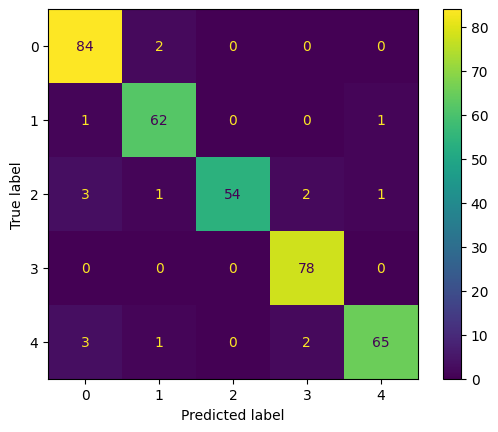

Decision Tree
model Accuracy : 79.4444%
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        86
           1       0.72      0.59      0.65        64
           2       0.77      0.79      0.78        61
           3       0.82      0.97      0.89        78
           4       0.84      0.80      0.82        71

    accuracy                           0.79       360
   macro avg       0.79      0.79      0.79       360
weighted avg       0.79      0.79      0.79       360



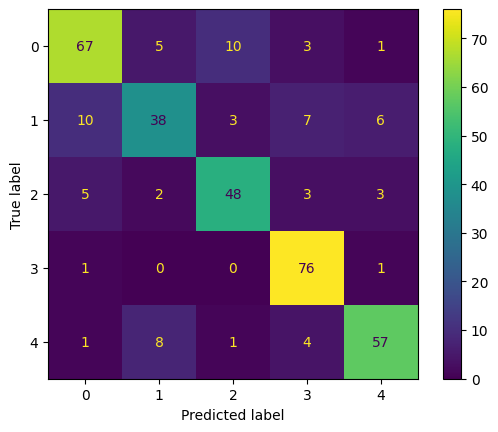

Logistic Regression
model Accuracy : 95.8333%
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        86
           1       0.94      0.95      0.95        64
           2       0.98      0.90      0.94        61
           3       0.96      0.99      0.97        78
           4       0.96      0.96      0.96        71

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



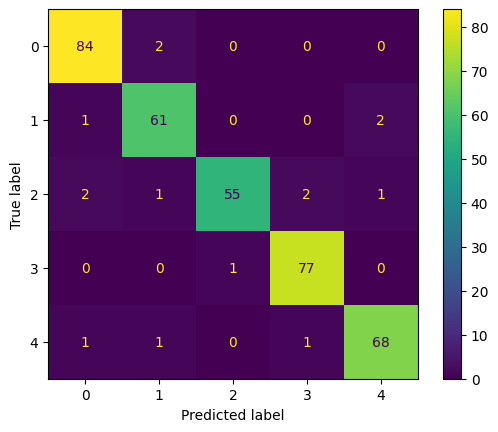

K-Neighbors Classifier
model Accuracy : 58.0556%
              precision    recall  f1-score   support

           0       0.82      0.57      0.67        86
           1       1.00      0.31      0.48        64
           2       1.00      0.48      0.64        61
           3       0.36      1.00      0.53        78
           4       0.94      0.46      0.62        71

    accuracy                           0.58       360
   macro avg       0.82      0.56      0.59       360
weighted avg       0.81      0.58      0.59       360



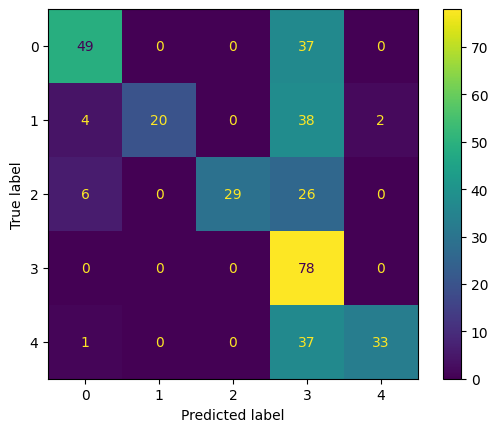

XGBClassifier
model Accuracy : 94.7222%
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        86
           1       0.91      0.95      0.93        64
           2       0.96      0.89      0.92        61
           3       0.95      1.00      0.97        78
           4       0.96      0.93      0.94        71

    accuracy                           0.95       360
   macro avg       0.95      0.94      0.95       360
weighted avg       0.95      0.95      0.95       360



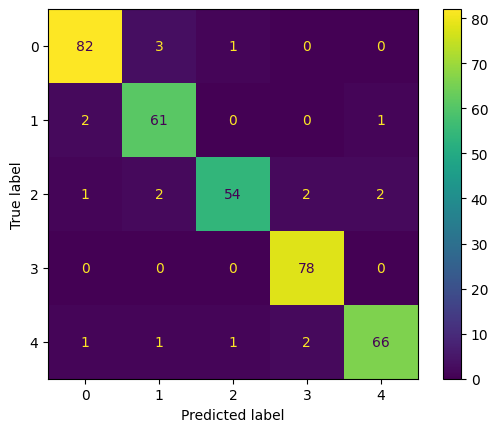

CatBoosting Classifier
model Accuracy : 95.5556%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        86
           1       0.92      0.94      0.93        64
           2       1.00      0.93      0.97        61
           3       0.95      0.99      0.97        78
           4       0.97      0.94      0.96        71

    accuracy                           0.96       360
   macro avg       0.96      0.95      0.96       360
weighted avg       0.96      0.96      0.96       360



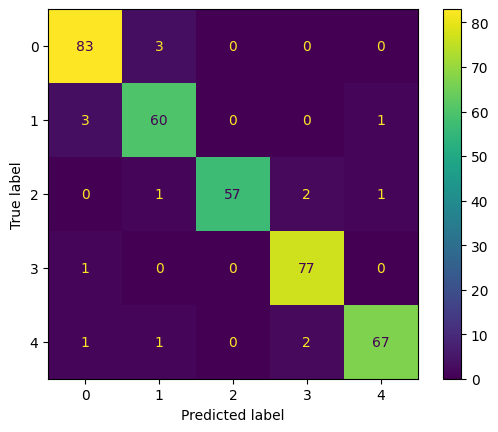

AdaBoost Classifier
model Accuracy : 75.0000%
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        86
           1       0.93      0.64      0.76        64
           2       0.68      0.74      0.71        61
           3       0.71      0.87      0.78        78
           4       0.80      0.66      0.72        71

    accuracy                           0.75       360
   macro avg       0.77      0.74      0.75       360
weighted avg       0.77      0.75      0.75       360



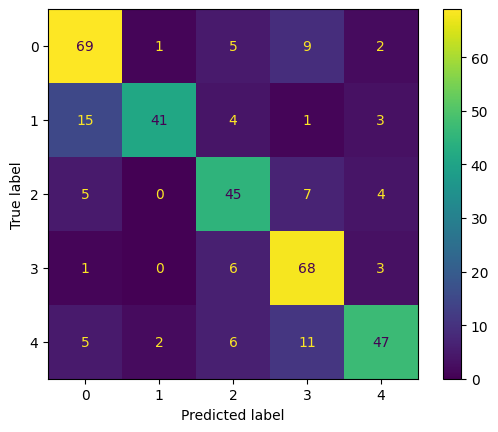

MultinomialNB
model Accuracy : 97.5000%
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        86
           1       0.91      0.98      0.95        64
           2       1.00      0.97      0.98        61
           3       1.00      1.00      1.00        78
           4       0.99      0.96      0.97        71

    accuracy                           0.97       360
   macro avg       0.98      0.97      0.97       360
weighted avg       0.98      0.97      0.98       360



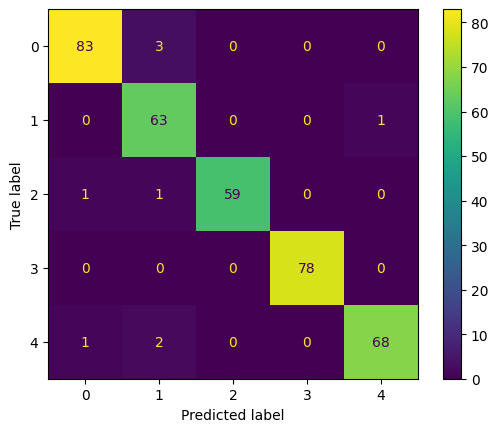

RidgeClassifier
model Accuracy : 91.6667%
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        86
           1       0.95      0.83      0.88        64
           2       0.95      0.85      0.90        61
           3       0.91      1.00      0.95        78
           4       0.89      0.94      0.92        71

    accuracy                           0.92       360
   macro avg       0.92      0.91      0.91       360
weighted avg       0.92      0.92      0.92       360



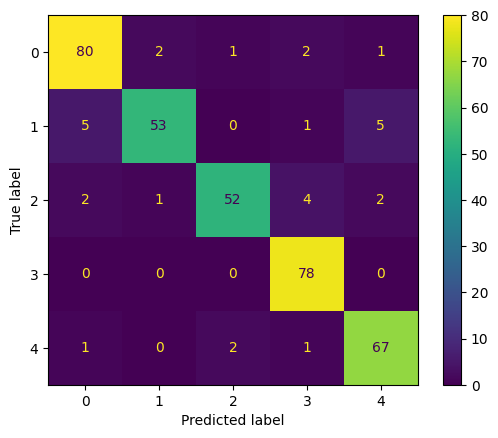

SGDClassifier
model Accuracy : 94.7222%
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        86
           1       0.92      0.95      0.94        64
           2       0.97      0.92      0.94        61
           3       0.94      0.99      0.96        78
           4       0.96      0.90      0.93        71

    accuracy                           0.95       360
   macro avg       0.95      0.94      0.95       360
weighted avg       0.95      0.95      0.95       360



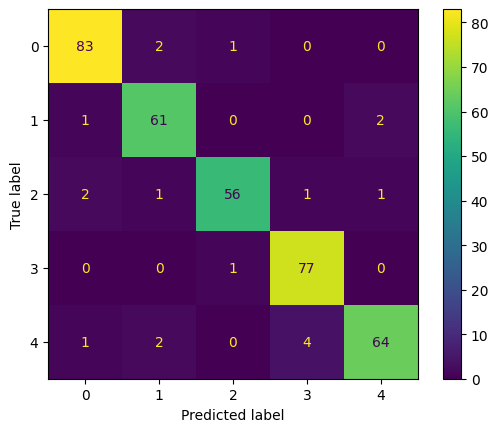

,accuracy,precision_macro,recall_macro,f1_macro
model,,,,
Random Forest,0.952778,0.956768,0.949247,0.951832
Decision Tree,0.794444,0.788847,0.787376,0.785466
Logistic Regression,0.958333,0.959079,0.955287,0.956771
K-Neighbors Classifier,0.580556,0.824127,0.564493,0.589024
XGBClassifier,0.947222,0.947193,0.944287,0.945144
CatBoosting Classifier,0.955556,0.957578,0.953577,0.955211
AdaBoost Classifier,0.750000,0.768979,0.742884,0.747008
MultinomialNB,0.975000,0.975004,0.974890,0.974578
RidgeClassifier,0.916667,0.920257,0.910896,0.913691


In [63]:
evaluate_models_(Xtrain_count,Xtest_count,y_train, y_test,models,scoring_metrics)